# Predict weekly data, single city (Deep Learning)

In [1]:
import os
from pathlib import Path


import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import zipfile


iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")
if iskaggle:
    path = Path("../rohanrao/air-quality-data-in-india")
else:
    full_path = Path("rohanrao/air-quality-data-in-india")
    owner_slug = str(full_path).split("/")[0]
    dataset_slug = str(full_path).split("/")[1]
    path = Path(dataset_slug)
    if not path.exists():
        import zipfile, kaggle

        kaggle.api.datasets_download(owner_slug=owner_slug, dataset_slug=dataset_slug)
        zipfile.ZipFile(f"{dataset_slug}.zip").extractall(dataset_slug)
    else:
        print(f"Path {path} exists")

Path air-quality-data-in-india exists


In [4]:
import torch, numpy as np, pandas as pd

In [5]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

In [50]:
df = pd.read_csv(path / "city_day.csv", parse_dates=["Date"])
df.Date = pd.to_datetime(df.Date)

df.set_index("Date", inplace=True)
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29531 entries, 2015-01-01 to 2020-07-01
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   PM2.5       24933 non-null  float64
 2   PM10        18391 non-null  float64
 3   NO          25949 non-null  float64
 4   NO2         25946 non-null  float64
 5   NOx         25346 non-null  float64
 6   NH3         19203 non-null  float64
 7   CO          27472 non-null  float64
 8   SO2         25677 non-null  float64
 9   O3          25509 non-null  float64
 10  Benzene     23908 non-null  float64
 11  Toluene     21490 non-null  float64
 12  Xylene      11422 non-null  float64
 13  AQI         24850 non-null  float64
 14  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(2)
memory usage: 3.6+ MB


None

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Ahmedabad,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
2015-01-02,Ahmedabad,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2015-01-03,Ahmedabad,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
2015-01-04,Ahmedabad,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
2015-01-05,Ahmedabad,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [51]:
df.dtypes

City           object
PM2.5         float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
CO            float64
SO2           float64
O3            float64
Benzene       float64
Toluene       float64
Xylene        float64
AQI           float64
AQI_Bucket     object
dtype: object

In [52]:
df.isna().sum()

City              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

In [53]:
df.describe(include=(np.number))

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000
mean,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581
std,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000
25%,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000
50%,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000
75%,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000


In [54]:
df.describe(include=[object])

,City,AQI_Bucket
count,29531,24850
unique,26,6
top,Ahmedabad,Moderate
freq,2009,8829


In [55]:
pollution_columns = ["PM2.5", "PM10", "O3", "CO", "SO2", "NO2"]

In [56]:
from asyncore import poll

delhi_df = df[df["City"] == "Delhi"][pollution_columns]
delhi_df.head()

,PM2.5,PM10,O3,CO,SO2,NO2
Date,,,,,,
2015-01-01,313.22,607.98,41.68,15.20,9.25,36.39
2015-01-02,186.18,269.55,29.97,9.54,6.65,32.87
2015-01-03,87.18,131.90,19.71,10.61,2.65,30.31
2015-01-04,151.84,241.84,25.36,11.54,4.63,36.91
2015-01-05,146.60,219.13,23.20,9.20,3.33,34.92


In [57]:
print(delhi_df.shape)
delhi_df.isna().sum()

(2009, 6)


PM2.5      2
PM10      77
O3        84
CO         0
SO2      110
NO2        2
dtype: int64

<AxesSubplot:xlabel='Date'>

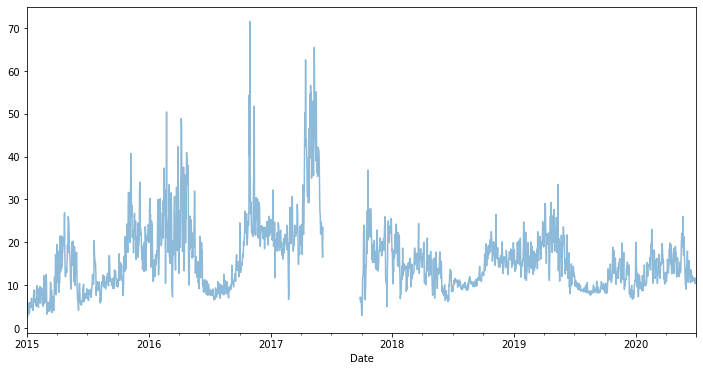

In [59]:
delhi_df["SO2"].plot(figsize=(12, 6), alpha=0.5)

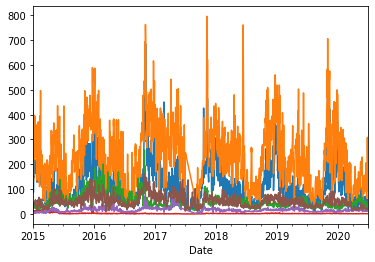

In [66]:
for column in pollution_columns:
    delhi_df[column] = delhi_df[column].interpolate()
    delhi_df[column].plot()

In [67]:
print(delhi_df.shape)
delhi_df.isna().sum()

(2009, 6)


PM2.5    0
PM10     0
O3       0
CO       0
SO2      0
NO2      0
dtype: int64

In [68]:
delhi_df_weekly = delhi_df.resample("w").mean()
delhi_df_weekly.head()

,PM2.5,PM10,O3,CO,SO2,NO2
Date,,,,,,
2015-01-04,184.605000,312.817500,29.180000,11.722500,5.795000,34.120000
2015-01-11,196.005714,337.294286,32.418571,10.171429,4.435714,41.187143
2015-01-18,187.650000,311.988571,35.515714,10.181429,5.451429,49.240000
2015-01-25,156.357143,217.318571,15.777143,9.458571,6.518571,24.634286
2015-02-01,162.784286,234.240000,17.501429,10.837143,6.471429,37.278571


In [69]:
delhi_df_daily = delhi_df.resample("D").mean()
delhi_df_daily.head()

,PM2.5,PM10,O3,CO,SO2,NO2
Date,,,,,,
2015-01-01,313.22,607.98,41.68,15.20,9.25,36.39
2015-01-02,186.18,269.55,29.97,9.54,6.65,32.87
2015-01-03,87.18,131.90,19.71,10.61,2.65,30.31
2015-01-04,151.84,241.84,25.36,11.54,4.63,36.91
2015-01-05,146.60,219.13,23.20,9.20,3.33,34.92


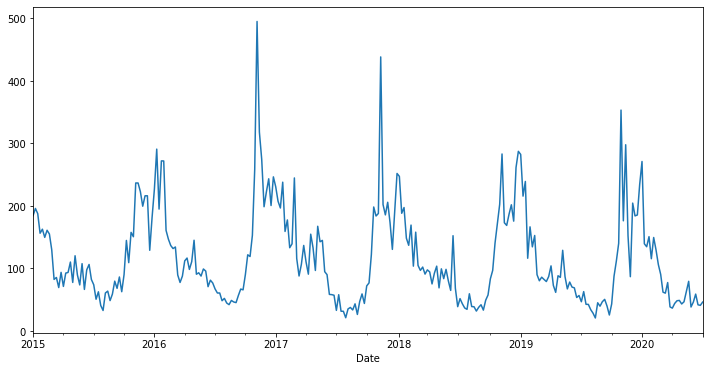

In [70]:
delhi_df_weekly["PM2.5"].plot(figsize=(12, 6))
plt.show()

<AxesSubplot:xlabel='Date'>

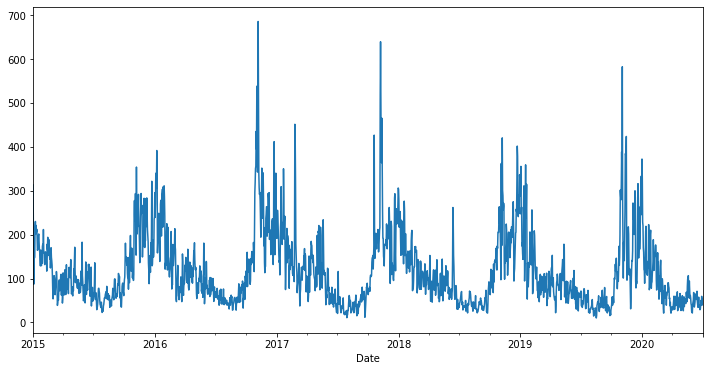

In [71]:
delhi_df_daily["PM2.5"].plot(figsize=(12, 6))

## FCN Approach

In [72]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout

In [73]:
delhi_df_weekly.columns

Index(['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2'], dtype='object')

## Comparing predictions to actual values

In [46]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-14,107.274970,-6.134080,75.893263,107.274970,107.274970,-74.842576,-74.842576,-74.842576,-74.842576,-74.842576,-74.842576,0.0,0.0,0.0,32.432394
1,2019-07-21,107.095897,-11.860216,71.864566,107.095897,107.096561,-77.599631,-77.599631,-77.599631,-77.599631,-77.599631,-77.599631,0.0,0.0,0.0,29.496266
2,2019-07-28,106.916824,-13.992866,70.497699,106.915611,106.922590,-80.954995,-80.954995,-80.954995,-80.954995,-80.954995,-80.954995,0.0,0.0,0.0,25.961828
3,2019-08-04,106.737750,-17.291875,59.832537,106.731842,106.750928,-83.625372,-83.625372,-83.625372,-83.625372,-83.625372,-83.625372,0.0,0.0,0.0,23.112379
4,2019-08-11,106.558677,-16.489269,64.647404,106.544915,106.583049,-82.088571,-82.088571,-82.088571,-82.088571,-82.088571,-82.088571,0.0,0.0,0.0,24.470106


In [49]:
import matplotlib.pyplot as plt



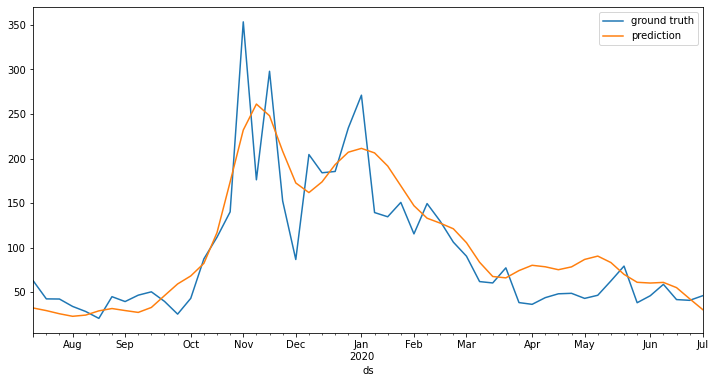

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

forecast_series = forecast.set_index(keys=["ds"]).iloc[-nobs:, :]
ground_truth_series = test.rename(columns={"Date": "ds", "PM2.5": "y"}).set_index(
    keys=["ds"]
)

ground_truth_series["y"].plot()
forecast_series["yhat"].plot()


ax.legend(["ground truth", "prediction"])

In [69]:
def calculate_RMSE(ground_truth, forecast):
    return np.sqrt(np.mean((ground_truth - forecast) ** 2))


calculate_RMSE(ground_truth_series["y"], forecast_series["yhat"])

36.34970386744316

In [ ]:
#TODO: take single year's data, make prediction, then 2 years etc. (which timespan gives best prediction?)
#TODO: try a prediction for 2023 (each Indian city)
#TODO: Plot weekly prediction for each city
# consdier location in country also

# External datasets as well - wind speed / direction & temperature
# Which method performs best with Pollution data
# Which metrics to use to find which method perform the best